In [1]:
import os
os.chdir("..")

In [2]:
import world_bank_data as wb
import pandas as pd
import polars as pl
import missingno as msno
import numpy as np
import pandas as pd
from src.data.data_pull import DataClean
import seaborn as sns
import matplotlib.pyplot as plt

dc = DataClean()

# TODO
- colapse by 5 average
- keep the balance data
- 

<Axes: >

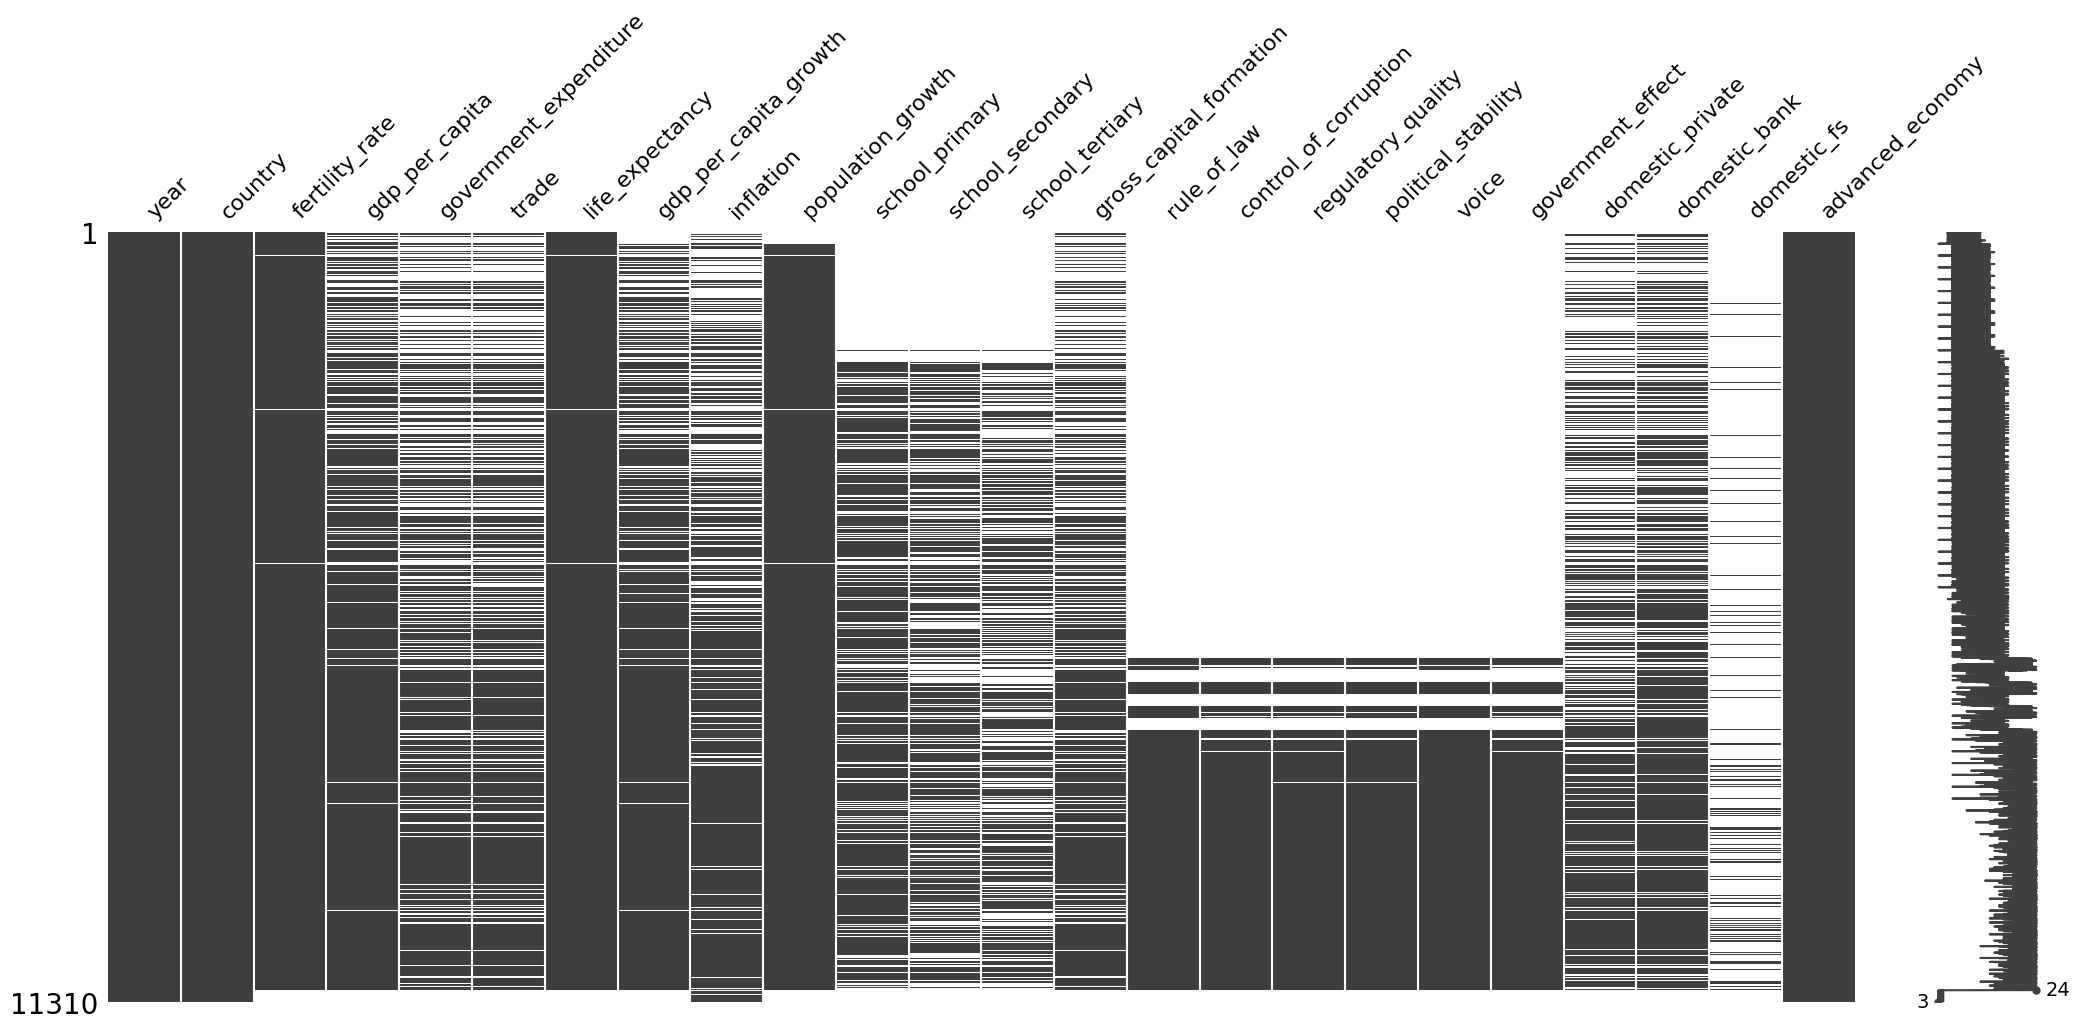

In [3]:
df = dc.pull_wb()
data = pl.read_csv("data/external/countries.csv")
df = df.join(data, on="country", how="inner", validate="m:1")
msno.matrix(df.to_pandas())

In [4]:
df = dc.pull_wb()
data = pl.read_csv("data/external/countries.csv")
df = df.join(data, on="country", how="inner", validate="m:1")


In [ ]:
df = df.filter(pl.col("year") >= 2002)
for cols in  df.columns:
    df = df.filter(pl.col(f"{cols}").is_not_null())

units = df.select("country").unique()

min_year = df["year"].min()
max_year = df["year"].max()
years = pl.DataFrame({"year": list(range(min_year, max_year + 1))})

full_index = units.join(years, how="cross")

full_df = full_index.join(df, on=["country", "year"], how="left")

msno.matrix(full_df.to_pandas().sort_values(["country","year"]))

In [ ]:
pivoted = full_df.pivot(
    values="school_primary",
    index="year",
    on="country"
)
msno.bar(pivoted.to_pandas(), sort='descending')

In [ ]:
pivoted = full_df.pivot(
    values="trade",
    index="country",
    on="year"
)
# pivoted.set_index(['year'], inplace=True)
msno.bar(pivoted.to_pandas())

In [ ]:
countries = pivoted.filter(pl.col("2005").is_not_null()).select(pl.col("country")).to_series().unique().to_list()
len(countries)

In [ ]:
df1 = full_df
df1 = df1.filter(pl.col("country").is_in(countries))
df1 = df1.filter((pl.col("year") >= 2002))
df1 = df1.to_pandas().sort_values(["year","country"])
msno.matrix(df1)

In [ ]:
len(df1.select(pl.col("country")).to_series().unique().to_list())

In [ ]:
df.write_csv("data/processed/dataset.csv")